# ML Challenge 

<img src="https://imageio.forbes.com/specials-images/imageserve/5ecd179f798e4c00060d2c7c/0x0.jpg?format=jpg&height=600&width=1200&fit=bounds" width="500" height="300">

In the bustling city of Financia, the Central Lending Institution (CLI) is the largest provider of loans to individuals and businesses. With a mission to support economic growth and financial stability, CLI processes thousands of loan applications every month. However, the traditional manual review process is time-consuming and prone to human error, leading to delays and inconsistencies in loan approvals.
To address these challenges, CLI has decided to leverage the power of machine learning to streamline their loan approval process. They have compiled a comprehensive dataset containing historical loan application records, including various factors such as credit scores, income levels, employment status, loan terms(measured in years), loan amounts, asset values, and the final loan status (approved or denied).


**Your task is to develop a predictive model that can accurately determine the likelihood of loan approval based on the provided features. By doing so, you will help CLI make faster, more accurate, and fairer lending decisions, ultimately contributing to the financial well-being of the community.**

It is recommended that you follow the typical machine learning workflow, though you are not required to strictly follow each steps: 
1. Data Collection: Gather the data you need for your model. (Already done for you)

2. Data Preprocessing: Clean and prepare the data for analysis. (Already done for you)

3. Exploratory Data Analysis (EDA): Understand the data and its patterns. (Partially done for you)

4. Feature Engineering: Create new features or modify existing ones to improve model performance. (Partially done for you)

5. Model Selection: Choose the appropriate machine learning algorithm.

6. Model Training: Train the model using the training dataset.

7. Model Evaluation: Evaluate the model's performance using a validation dataset.

8. Model Optimization: Optimize the model's parameters to improve performance.

9. Model Testing: Test the final model on a separate test dataset.

**Please include ALL your work and thought process in this notebook**

In [14]:
# You may include any package you deem fit. We sugggest looking into Scikit-learn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


## Dataset


In [2]:
# DO NOT MODIFY
loan_data = pd.read_csv("../../data/loan_approval.csv")


## EDA
Uncomment to see desired output. Add more analysis if you like

Index(['loan_id', 'no_of_dependents', 'education', 'self_employed',
       'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status'],
      dtype='object')
           loan_id  no_of_dependents  income_annum   loan_amount    loan_term  \
count  4269.000000       4269.000000  4.269000e+03  4.269000e+03  4269.000000   
mean   2135.000000          2.498712  5.059124e+06  1.513345e+07    10.900445   
std    1232.498479          1.695910  2.806840e+06  9.043363e+06     5.709187   
min       1.000000          0.000000  2.000000e+05  3.000000e+05     2.000000   
25%    1068.000000          1.000000  2.700000e+06  7.700000e+06     6.000000   
50%    2135.000000          3.000000  5.100000e+06  1.450000e+07    10.000000   
75%    3202.000000          4.000000  7.500000e+06  2.150000e+07    16.000000   
max    4269.000000          5.000000  9.900000e+06  3.950000e+07    

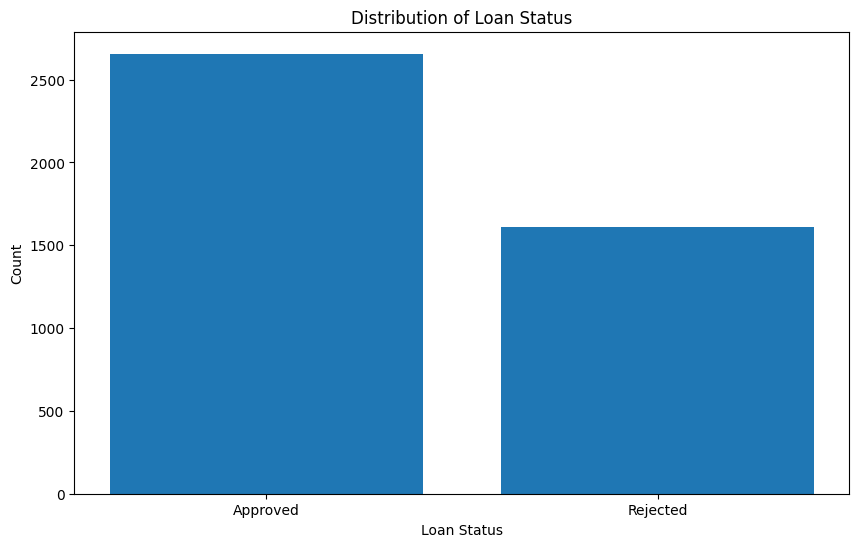

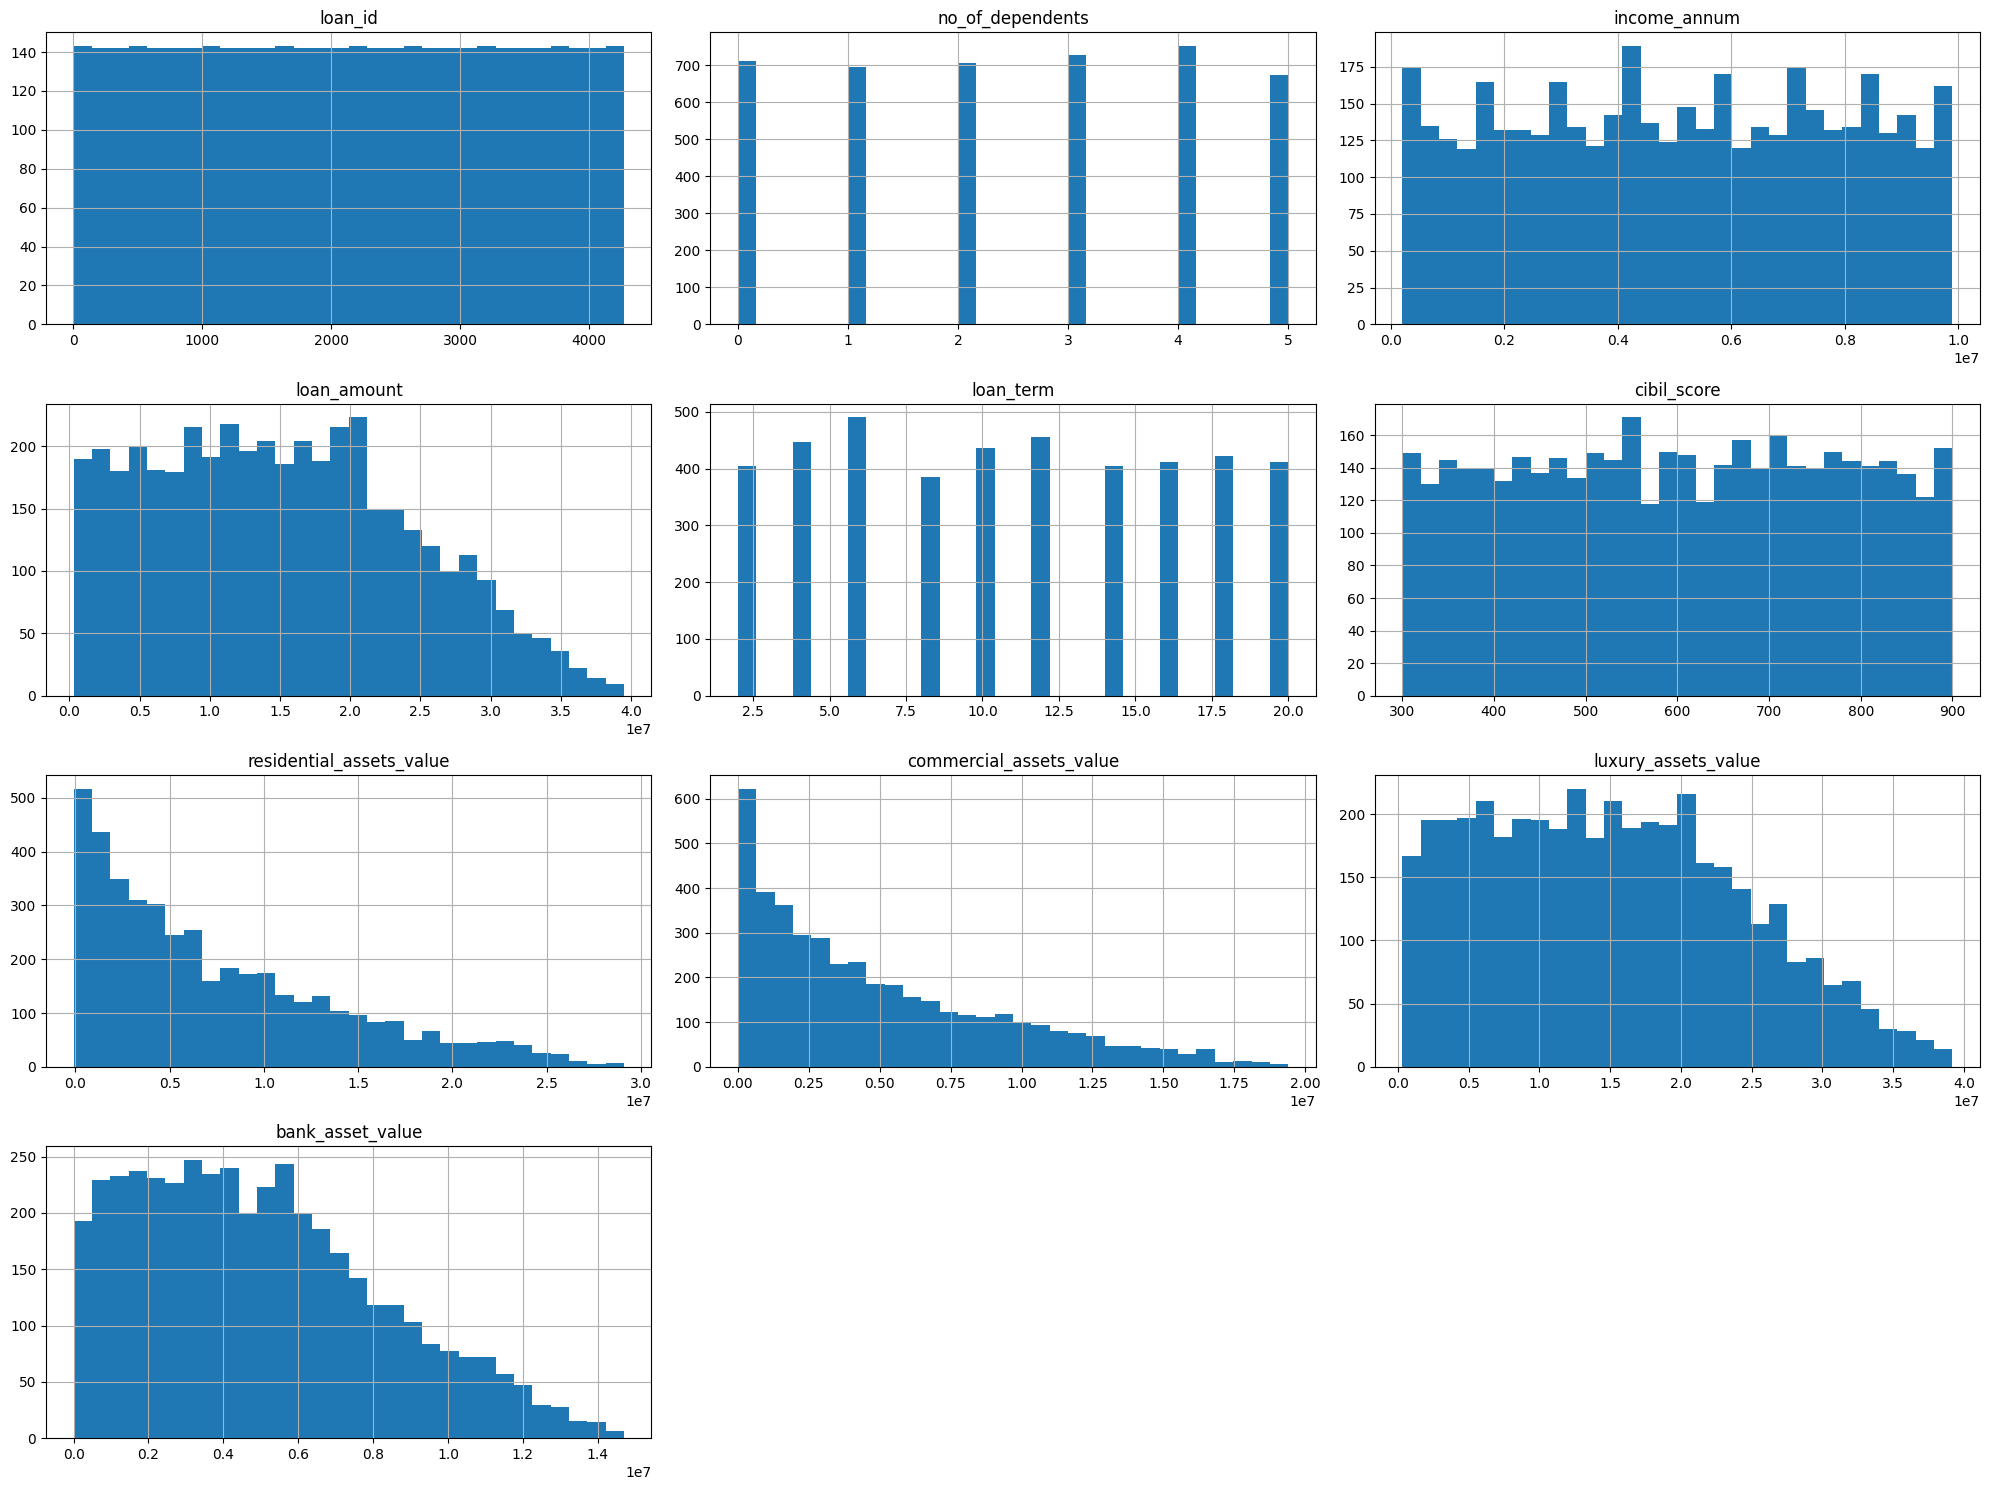

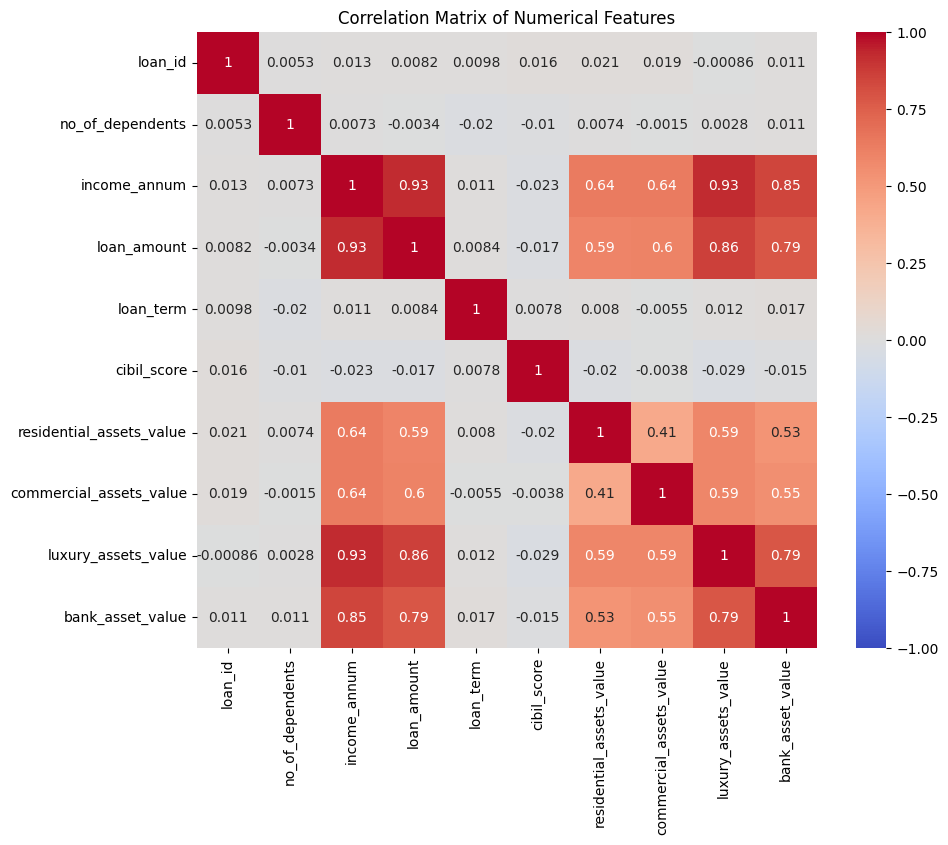

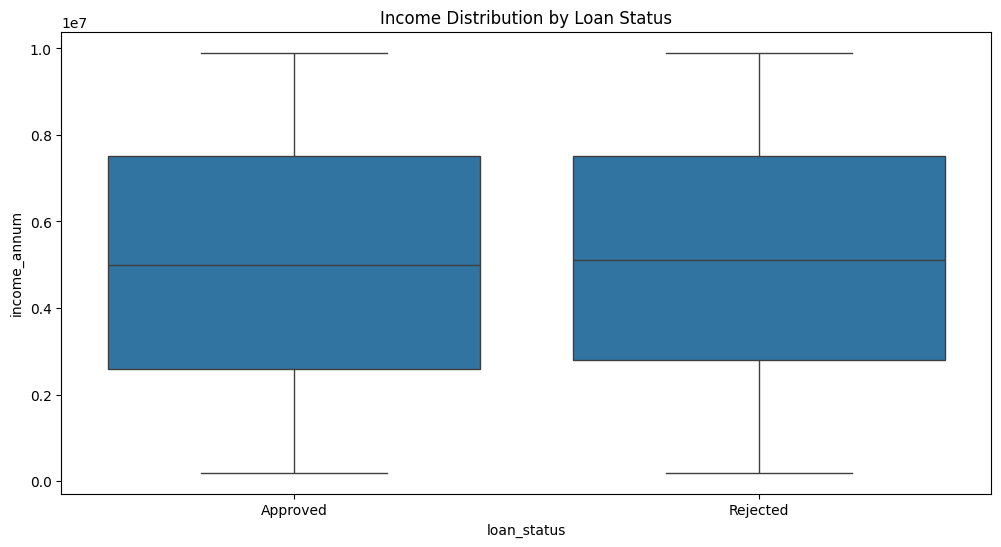

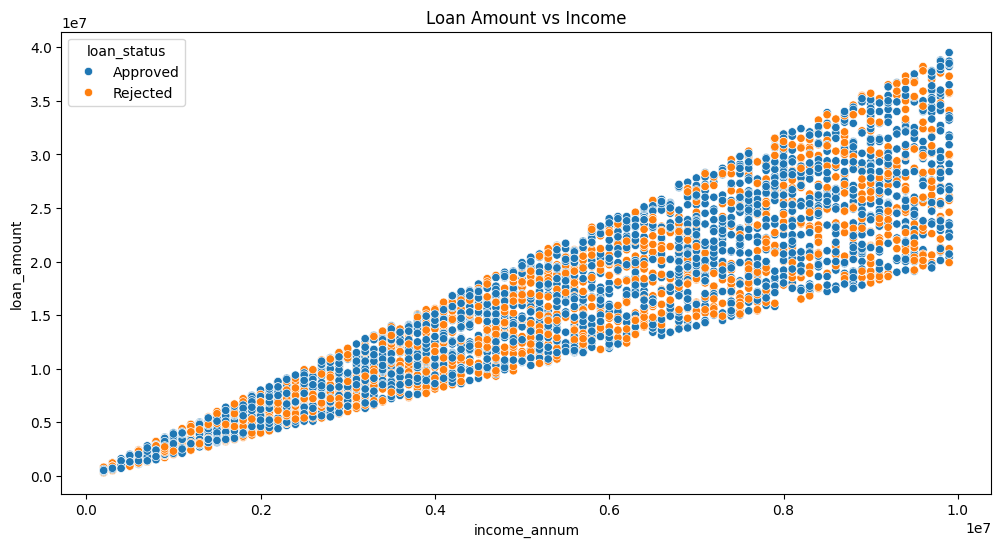

loan_status
Approved    0.62216
Rejected    0.37784
Name: proportion, dtype: float64


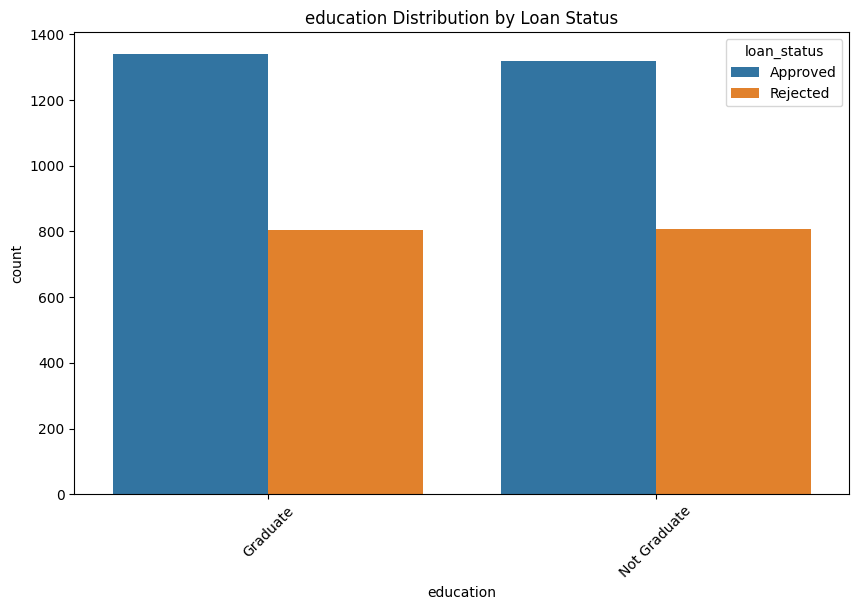

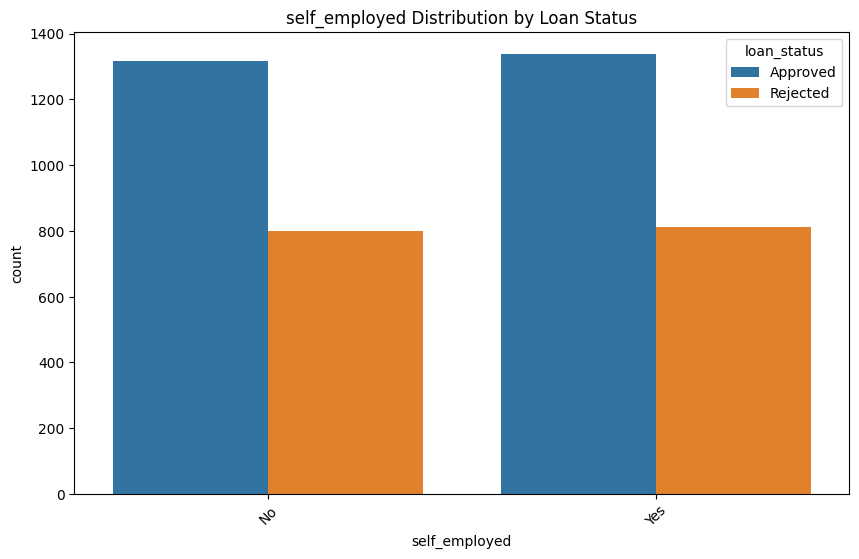

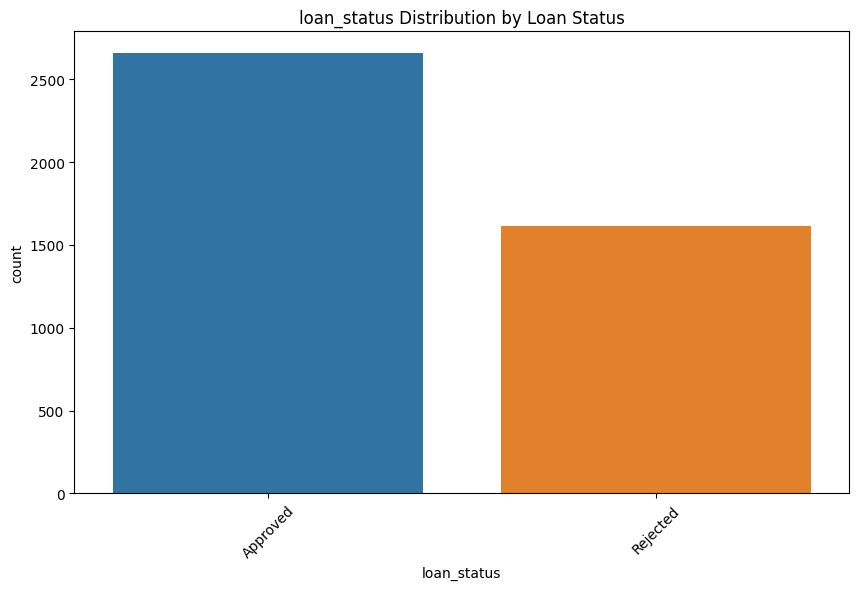

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# ------ Display basic information ------
print(loan_data.columns)
print(loan_data.describe())

# ------ Check for missing values ------
print(loan_data.isnull().sum())

# ------ Visualize the distribution of loan status ------
loan_status_counts = loan_data['loan_status'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(loan_status_counts.index, loan_status_counts.values)
plt.title('Distribution of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

# ------ Visualize the distribution of numerical features ------
numerical_columns = loan_data.select_dtypes(include=['int64', 'float64']).columns
loan_data[numerical_columns].hist(bins=30, figsize=(20, 15))
plt.tight_layout()
plt.show()

# ------ Correlation matrix for numerical features ------
corr_matrix = loan_data[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# ------ Additional EDA ------
plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_status', y='income_annum', data=loan_data)
plt.title('Income Distribution by Loan Status')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='income_annum', y='loan_amount', hue='loan_status', data=loan_data)
plt.title('Loan Amount vs Income')
plt.show()

# Checking class balance
print(loan_data['loan_status'].value_counts(normalize=True))

# ------ Categorical variable analysis ------
categorical_columns = loan_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='loan_status', data=loan_data)
    plt.title(f'{col} Distribution by Loan Status')
    plt.xticks(rotation=45)
    plt.show()

## Feature Engineering

You may want to convert categorical variables to numerical. For example, education takes on the value Graduate and Not Graduate. But we want it to be 0 or 1 for machine learning algorithms to use.

In [7]:
# Convert categorical variables to numerical
loan_data['education'] = loan_data['education'].map({'Graduate': 1, 'Not Graduate': 0})
loan_data['self_employed'] = loan_data['self_employed'].map({'Yes': 1, 'No': 0})
loan_data['loan_status'] = loan_data['loan_status'].map({'Approved': 1, 'Rejected': 0})

# Create new features
loan_data['debt_to_income'] = loan_data['loan_amount'] / loan_data['income_annum']
loan_data['total_assets'] = (
    loan_data['residential_assets_value'] + 
    loan_data['commercial_assets_value'] + 
    loan_data['luxury_assets_value'] + 
    loan_data['bank_asset_value']
)
loan_data['asset_to_loan'] = loan_data['total_assets'] / loan_data['loan_amount']

# Display the first few rows of the updated dataset
print(loan_data.head())

   loan_id  no_of_dependents  education  self_employed  income_annum  \
0        1                 2          1              0       9600000   
1        2                 0          0              1       4100000   
2        3                 3          1              0       9100000   
3        4                 3          1              0       8200000   
4        5                 5          0              1       9800000   

   loan_amount  loan_term  cibil_score  residential_assets_value  \
0     29900000         12          778                   2400000   
1     12200000          8          417                   2700000   
2     29700000         20          506                   7100000   
3     30700000          8          467                  18200000   
4     24200000         20          382                  12400000   

   commercial_assets_value  luxury_assets_value  bank_asset_value  \
0                 17600000             22700000           8000000   
1                  2

## Model Selection

You are free to use any classification machine learning models you like: Logistic Regression, Decision Trees/Random Forests, Support Vector Machines, KNN ... 

In [8]:
# Prepare features and target
X = loan_data.drop('loan_status', axis=1)
y = loan_data['loan_status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define hyperparameters to tune
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.9997071742313324


## Model Training and Evaluation

Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       318
           1       1.00      1.00      1.00       536

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg       1.00      1.00      1.00       854



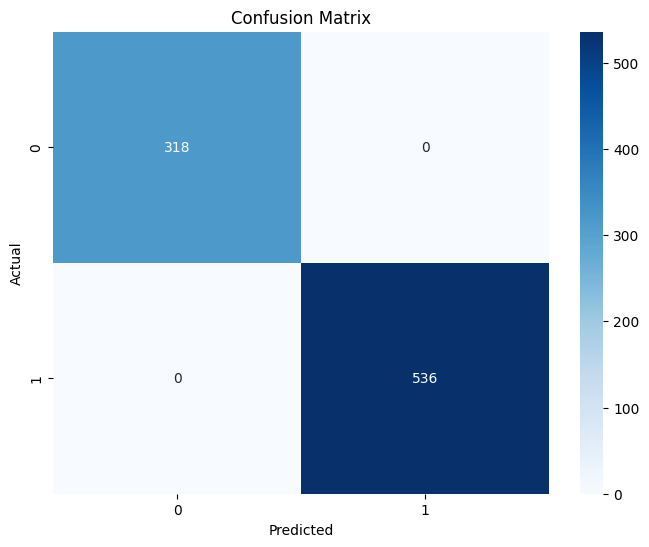

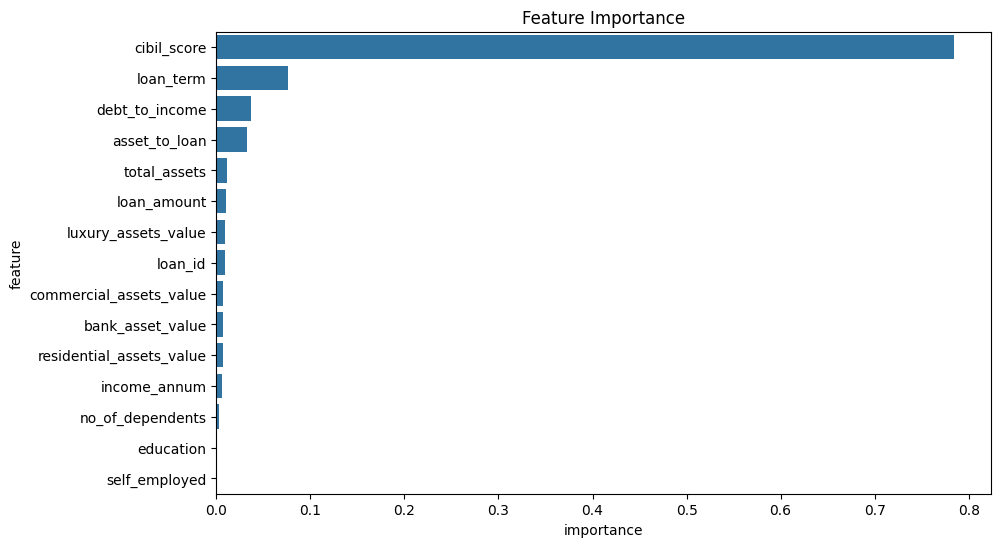

In [9]:
# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance
feature_importance = best_model.named_steps['classifier'].feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

## Model Optimization and Testing

In [15]:
# Perform final evaluation on the test set
final_accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {final_accuracy:.4f}")

# Make predictions on a sample loan application
sample_application = pd.DataFrame({
    'loan_id': [1000],  # Arbitrary loan ID
    'no_of_dependents': [2],
    'education': [1],  # Graduate
    'self_employed': [0],  # No
    'income_annum': [5000000],
    'loan_amount': [20000000],
    'loan_term': [10],
    'cibil_score': [700],
    'residential_assets_value': [5000000],
    'commercial_assets_value': [10000000],
    'luxury_assets_value': [2000000],
    'bank_asset_value': [3000000],
    'debt_to_income': [4],  # 20000000 / 5000000
    'total_assets': [20000000],  # Sum of all asset values
    'asset_to_loan': [1]  # 20000000 / 20000000
})

prediction = best_model.predict(sample_application)
probability = best_model.predict_proba(sample_application)

print("\nSample Loan Application:")
print(sample_application)
print(f"\nPrediction: {'Approved' if prediction[0] == 1 else 'Rejected'}")
print(f"Probability of Approval: {probability[0][1]:.2f}")


Final Model Accuracy: 1.0000

Sample Loan Application:
   loan_id  no_of_dependents  education  self_employed  income_annum  \
0     1000                 2          1              0       5000000   

   loan_amount  loan_term  cibil_score  residential_assets_value  \
0     20000000         10          700                   5000000   

   commercial_assets_value  luxury_assets_value  bank_asset_value  \
0                 10000000              2000000           3000000   

   debt_to_income  total_assets  asset_to_loan  
0               4      20000000              1  

Prediction: Approved
Probability of Approval: 0.80
